In [1]:
import collections

import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

D:\Users\Anton\AppData\Local\Programs\Python\Python38\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Подгрузка данных

In [2]:
G_drive = ox.load_graphml('openstreetmap-data/moscow-bbox-drive.graphml')

In [3]:
nodes_drive_gdf, edges_drive_gdf = ox.graph_to_gdfs(G_drive)

nodes_drive_gdf.head()

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
27717690,55.890551,37.483863,traffic_signals,3,NaN,POINT (37.48386 55.89055)
27778911,55.893697,37.482682,NaN,3,NaN,POINT (37.48268 55.89370)
27778949,55.895172,37.480244,NaN,3,NaN,POINT (37.48024 55.89517)
28041755,55.827504,37.764822,NaN,4,NaN,POINT (37.76482 55.82750)
28043165,55.813265,37.735747,traffic_signals,4,NaN,POINT (37.73575 55.81326)


# Анализ графа

### Определение community

In [4]:
communities = nx.community.greedy_modularity_communities(
    G_drive, weight='length', resolution=1)

In [5]:
rng = np.random.default_rng(1000)

# Цвета community.
community_colors = {}

# Каждому community присвоить цвет и вершину "центра".
for idx, community in enumerate(communities):
    # Присвоить цвет.
    community_colors[idx] = rng.random(3)

    # Получить подграф по вершинам community.
    community_subgraph = G_drive.subgraph(community)
    # Получить вершины самого большого связанного подграфа.
    strong_community = sorted(
        nx.strongly_connected_components(community_subgraph),
        key=lambda x: len(x), reverse=True)[0]
    # Получить самый большой связанный подграф.
    strong_community_subgraph = G_drive.subgraph(strong_community)

    # Расчитать "центр" подграфа.
    community_center = nx.barycenter(
        strong_community_subgraph, weight='length')[0]

    # Присвоить данные каждой вершине community.
    for v in community:
        G_drive.nodes[v]['community'] = idx
        G_drive.nodes[v]['community_center'] = community_center

# Создать список цветов вершин.
node_colors = [
    community_colors[G_drive.nodes[v]['community']] for v in G_drive.nodes]

In [6]:
# Получить центры.
community_centers = set(
    G_drive.nodes[v]['community_center'] for v in G_drive.nodes)
node_communities = {v: G_drive.nodes[v]['community'] for v in G_drive.nodes}

### Соседние центры

In [7]:
# Для хранения данных о соседях (всех + из которых есть путь в текущий центр).
preceeding_communities = collections.defaultdict(set)
neighboring_communities = collections.defaultdict(set)

# Получить для каждого центра соседей на основе того, какие community
# находятся рядом.
for v in G_drive.nodes:
    node_community = G_drive.nodes[v]['community']

    # Получить всех "предшедствующих" соседей.
    preceeding_neighbors = set(G_drive.predecessors(v))
    preceeding_neighbor_communities = set(
        node_communities[i] for i in preceeding_neighbors)

    preceeding_communities[node_community] |= preceeding_neighbor_communities

    # Теперь получить всех соседей.
    neighbors = preceeding_neighbors | set(G_drive.successors(v))
    neighbor_communities = set(node_communities[i] for i in neighbors)

    neighboring_communities[node_community] |= neighbor_communities

In [8]:
# Создать граф центров и их отношений.
G_communities = G_drive.subgraph(community_centers).copy()
G_communities = nx.relabel_nodes(G_communities, node_communities)
edge_keys = G_communities.add_edges_from(
    [(u, v)
    for v, neighbors in neighboring_communities.items()
    for u in neighbors])
# Для визуального представления можно использовать граф без направлений.
G_communities = G_communities.to_undirected()

In [9]:
nodes_communities_gdf, edges_communities_gdf = ox.graph_to_gdfs(G_communities)

nodes_communities_gdf.head()

,y,x,highway,street_count,community,community_center,ref,geometry
osmid,,,,,,,,
187,55.832238,37.659001,traffic_signals,3,187,316954626,NaN,POINT (37.65900 55.83224)
199,55.595378,37.443089,NaN,3,199,619265538,NaN,POINT (37.44309 55.59538)
67,55.845545,37.580651,NaN,4,67,303124486,NaN,POINT (37.58065 55.84554)
112,55.627115,37.337296,NaN,4,112,277811720,NaN,POINT (37.33730 55.62711)
54,55.809087,37.715373,traffic_signals,4,54,56191500,NaN,POINT (37.71537 55.80909)


### Визуализация

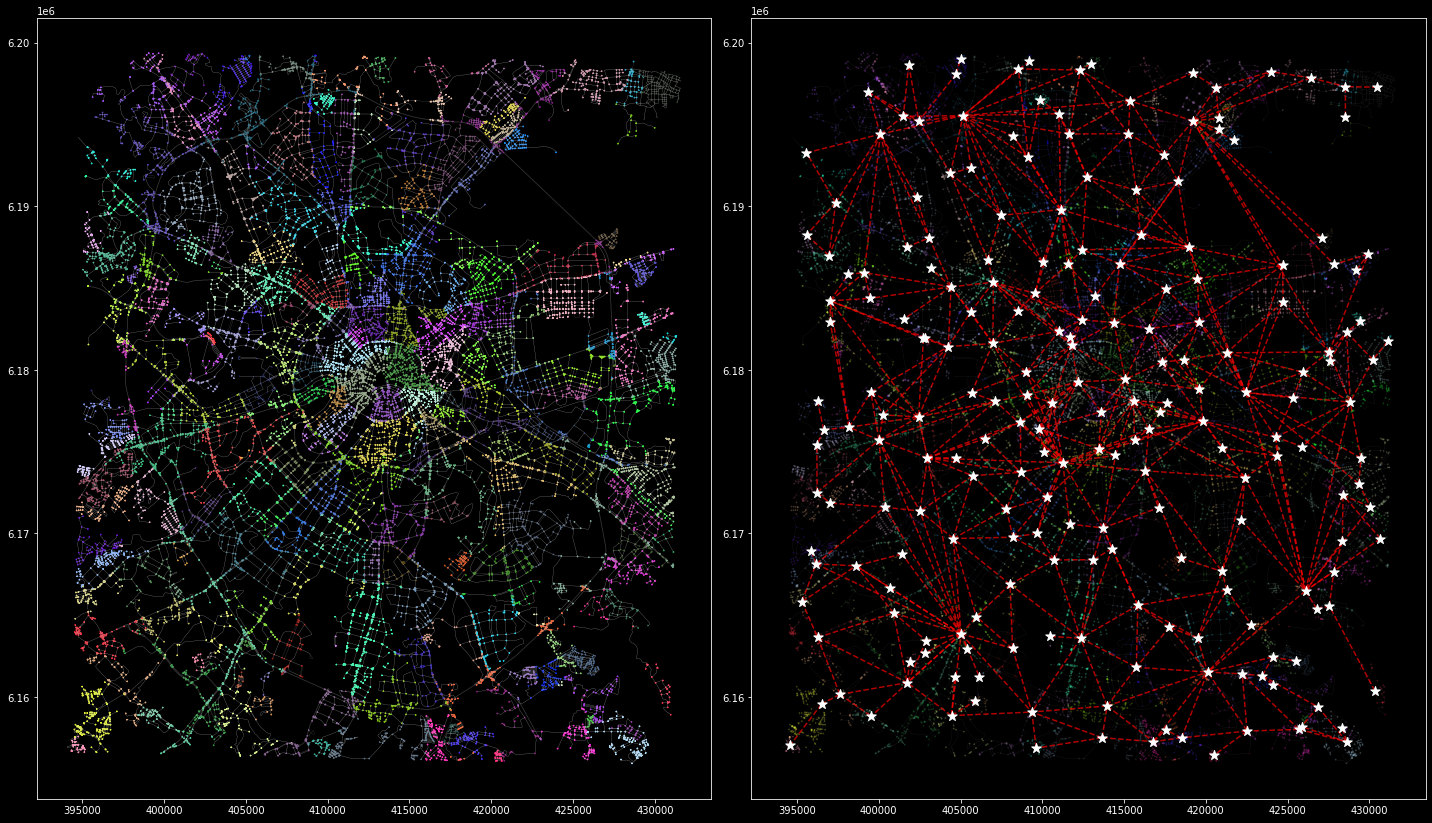

In [10]:
with plt.style.context('dark_background'):
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))

    # Создать два графика.
    for idx, ax in enumerate(axs):
        # Отобразить дороги и закрасить цветами community.

        # На втором графике сделать дороги более прозрачными.
        baseline_alpha = 1 if idx == 0 else 0.2

        ox.project_gdf(edges_drive_gdf).plot(
            ax=ax, color='lightgray', linewidth=0.1,
            alpha=baseline_alpha)
        ox.project_gdf(nodes_drive_gdf).plot(
            ax=ax, color=node_colors, marker='X', markersize=0.5,
            alpha=baseline_alpha)

        # На втором графике нарисовать центры и их отношения.
        if idx == 1:
            ox.project_gdf(edges_communities_gdf).plot(
                ax=ax, color='red', linewidth=1.5, linestyle='dashed',
                alpha=0.7)
            ox.project_gdf(nodes_communities_gdf).plot(
                ax=ax, color='white', marker='*', markersize=100, zorder=3)

    fig.tight_layout()